In [ ]:
!tar -xvf "/content/aclImdb_v1.tar"

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import nltk
import torch
import contractions
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments, BertForSequenceClassification

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Data Preprocessing Functions
def remove_html_tags(text):
    """Removes HTML tags and extra whitespace from text."""
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def expand_contractions(text):
    """Expands common contractions in text."""
    return contractions.fix(text)

def remove_special_characters(text):
    """Removes special characters and numbers."""
    return re.sub(r'[^a-zA-Z\s<>]', '', text)

def to_lowercase(text):
    """Converts text to lowercase."""
    return text.lower()

def tokenize(text):
    """Tokenizes text into words."""
    return word_tokenize(text)

def remove_stopwords(tokens):
    """Removes common stopwords from tokenized text."""
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def lemmatize(tokens):
    """Lemmatizes tokens to their base forms."""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# Preprocessing function for Word2Vec
def preprocess_text_for_word2vec(text):
    """Cleans and preprocesses text for Word2Vec."""
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = remove_special_characters(text)
    text = to_lowercase(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    return tokens

class IMDbDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        # Tokenize the review using BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Function to read IMDb reviews from a directory
def read_imdb_reviews(directory):
    """Reads all text files from a directory and returns a list of reviews."""
    reviews = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                review = file.read()
                reviews.append(review)
    return reviews

# Path to IMDb dataset
dataset_dir = r"/content/aclImdb"

# Read train and test reviews
train_pos_reviews = read_imdb_reviews(os.path.join(dataset_dir, "train", "pos"))
train_neg_reviews = read_imdb_reviews(os.path.join(dataset_dir, "train", "neg"))
test_pos_reviews = read_imdb_reviews(os.path.join(dataset_dir, "test", "pos"))
test_neg_reviews = read_imdb_reviews(os.path.join(dataset_dir, "test", "neg"))

# Combine and label the train and test reviews
train_reviews = pd.DataFrame({
    'review': train_pos_reviews + train_neg_reviews,
    'sentiment': ['positive'] * len(train_pos_reviews) + ['negative'] * len(train_neg_reviews)
})
test_reviews = pd.DataFrame({
    'review': test_pos_reviews + test_neg_reviews,
    'sentiment': ['positive'] * len(test_pos_reviews) + ['negative'] * len(test_neg_reviews)
})

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Preprocess the reviews for Word2Vec
train_reviews['review_word2vec'] = train_reviews['review'].apply(preprocess_text_for_word2vec)
test_reviews['review_word2vec'] = test_reviews['review'].apply(preprocess_text_for_word2vec)
train_data_word2vec = train_reviews['review_word2vec'].tolist()
test_data_word2vec = test_reviews['review_word2vec'].tolist()

# Convert sentiment to binary labels for BERT (0 for negative, 1 for positive)
train_reviews['sentiment'] = train_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
test_reviews['sentiment'] = test_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

train_data, val_data = train_test_split(train_reviews, test_size=0.1, random_state=42)

# Create BERT Datasets
train_dataset = IMDbDataset(
    reviews=train_data['review'].to_numpy(),
    labels=train_data['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = IMDbDataset(
    reviews=val_data['review'].to_numpy(),
    labels=val_data['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = IMDbDataset(
    reviews=test_reviews['review'].to_numpy(),
    labels=test_reviews['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
pos_reviews = pd.DataFrame({'review' : train_pos_reviews})
neg_reviews = pd.DataFrame({'review' : train_neg_reviews})
print(pos_reviews.head())
print(neg_reviews.head())

                                              review
0  I first saw this version of "A Christmas Carol...
1  This is a great movie from the lost age of rea...
2  Yes, Keaton looks like he really did enjoy mak...
3  Stupid, Stupid, Stupid. I think that Angelina ...
4  In this glorious telling of a weekend shared a...
                                              review
0  I think Cliff Robertson certainly was one of o...
1  "I Love New York" is another entry by VH-1 (MT...
2  Where to start... If this movie had been a dar...
3  It's very sad that Lucian Pintilie does not st...
4  Deep Shock plays out like a TV movie: a whole ...


1. Sentiment Distribution

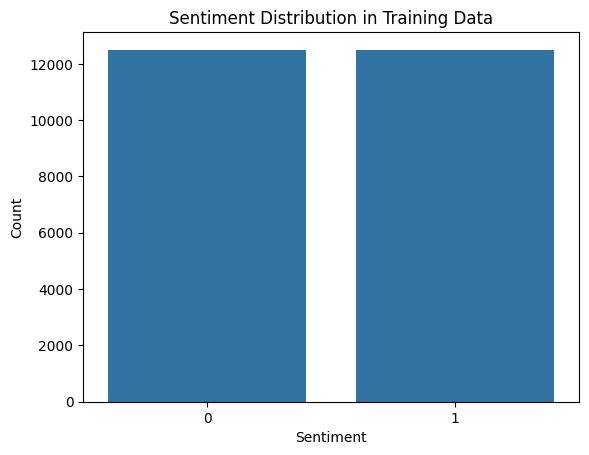

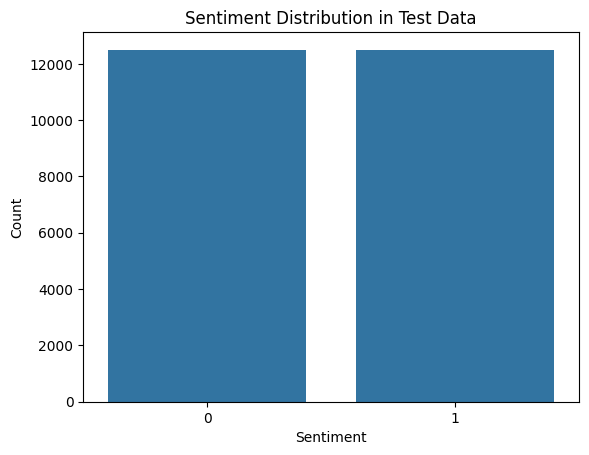

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution for training data
sns.countplot(x='sentiment', data=train_reviews)
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot sentiment distribution for test data
sns.countplot(x='sentiment', data=test_reviews)
plt.title('Sentiment Distribution in Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

2. Review Length Distribution

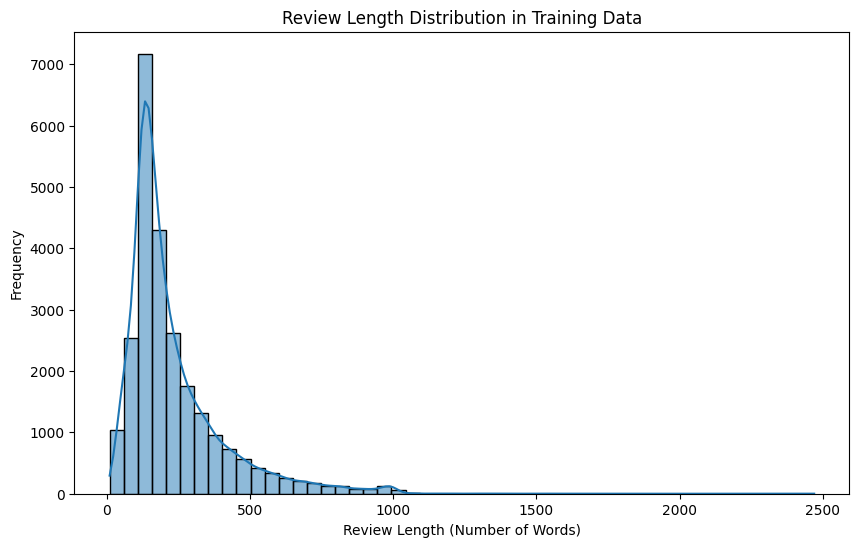

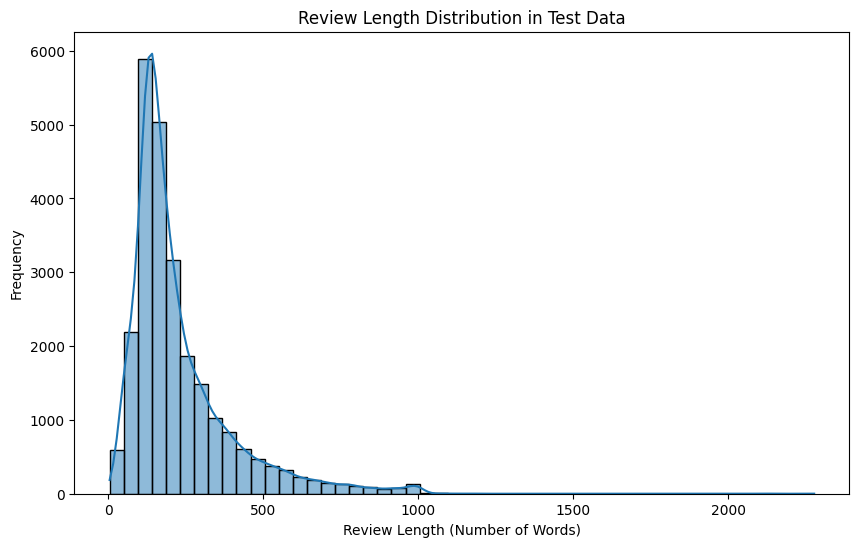

In [ ]:
# Calculate review lengths for training data
train_reviews['review_length'] = train_reviews['review'].apply(lambda x: len(x.split()))

# Calculate review lengths for test data
test_reviews['review_length'] = test_reviews['review'].apply(lambda x: len(x.split()))

# Plot review length distribution for training data
plt.figure(figsize=(10, 6))
sns.histplot(train_reviews['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution in Training Data')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

# Plot review length distribution for test data
plt.figure(figsize=(10, 6))
sns.histplot(test_reviews['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution in Test Data')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

3. Word Frequency: Most Common Words in Positive vs Negative Reviews


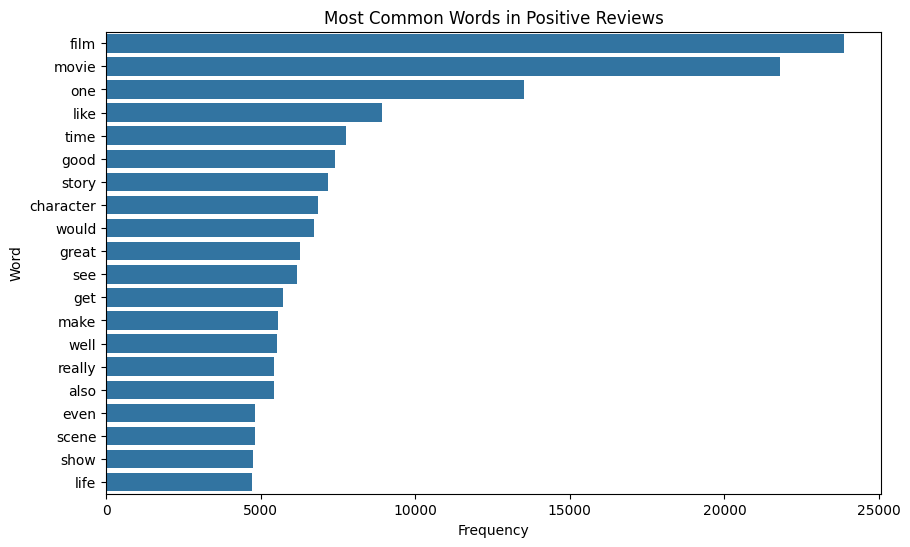

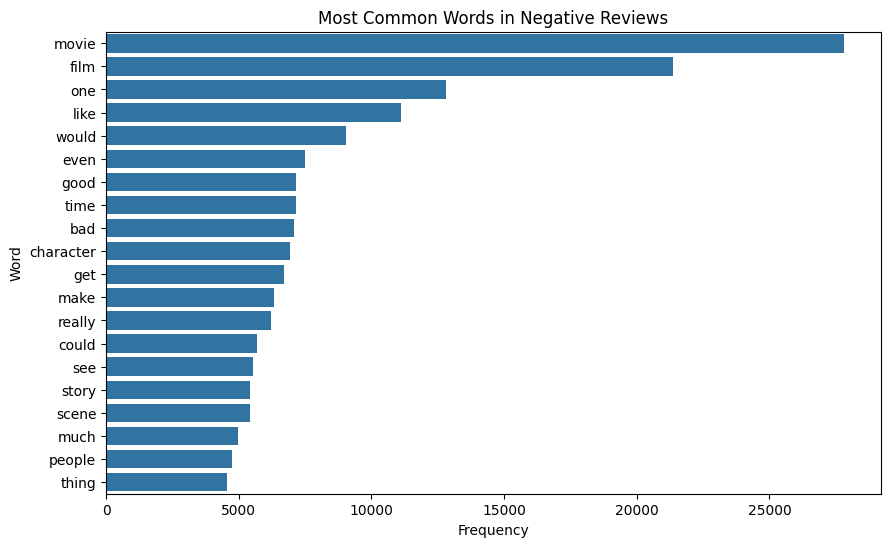

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenize and remove stopwords for word frequency analysis
def preprocess_for_word_freq(reviews):
    """Preprocess the reviews for word frequency analysis."""
    reviews = reviews.apply(preprocess_text_for_word2vec)  # Use the previously defined preprocessing function
    all_words = [word for review in reviews for word in review]  # Flatten the list of lists into a single list of words
    return all_words

# Word frequency in positive reviews
positive_reviews = train_reviews[train_reviews['sentiment'] == 1]['review']  # Select positive reviews
positive_words = preprocess_for_word_freq(positive_reviews)
positive_word_freq = Counter(positive_words).most_common(20)  # Get the 20 most common words

# Word frequency in negative reviews
negative_reviews = train_reviews[train_reviews['sentiment'] == 0]['review']  # Select negative reviews
negative_words = preprocess_for_word_freq(negative_reviews)
negative_word_freq = Counter(negative_words).most_common(20)  # Get the 20 most common words

# Plot most common words in positive reviews
positive_df = pd.DataFrame(positive_word_freq, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=positive_df)
plt.title('Most Common Words in Positive Reviews')
plt.show()

# Plot most common words in negative reviews
negative_df = pd.DataFrame(negative_word_freq, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=negative_df)
plt.title('Most Common Words in Negative Reviews')
plt.show()

4: Calculate review lengths (number of words)

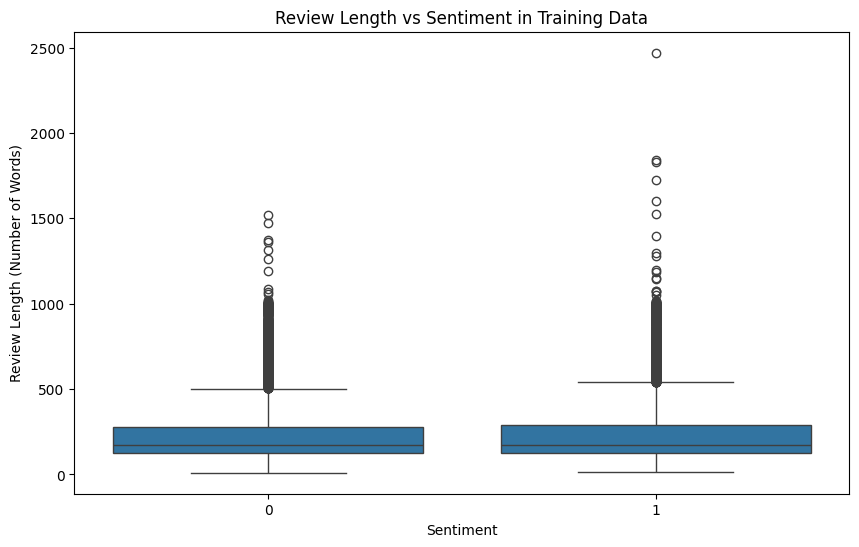

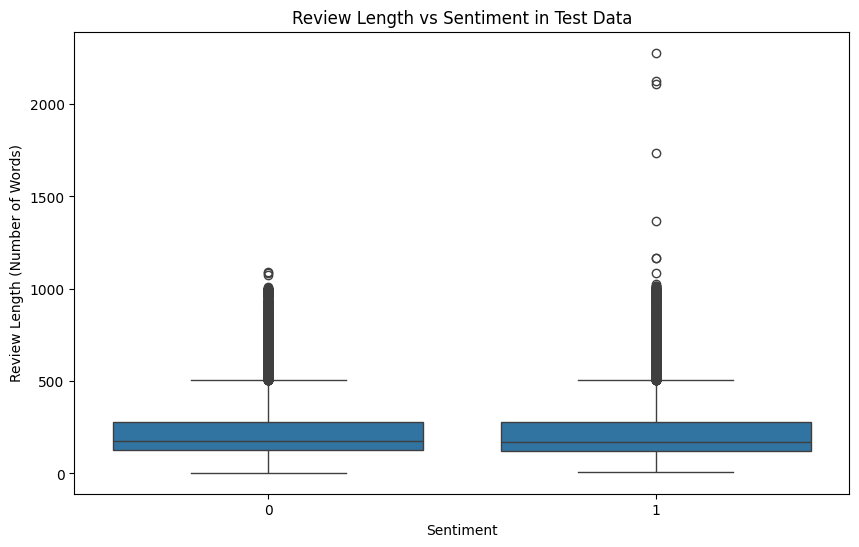

Average Review Length in Training Data:
 sentiment
0    230.86784
1    236.70656
Name: review_length, dtype: float64
Average Review Length in Test Data:
 sentiment
0    228.06128
1    228.99208
Name: review_length, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_reviews['review_length'] = train_reviews['review'].apply(lambda x: len(x.split()))
test_reviews['review_length'] = test_reviews['review'].apply(lambda x: len(x.split()))

# Plot Review Length vs. Sentiment for Training Data
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=train_reviews)
plt.title('Review Length vs Sentiment in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Number of Words)')
plt.show()

# Plot Review Length vs. Sentiment for Test Data
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=test_reviews)
plt.title('Review Length vs Sentiment in Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Number of Words)')
plt.show()


avg_review_length_train = train_reviews.groupby('sentiment')['review_length'].mean()
avg_review_length_test = test_reviews.groupby('sentiment')['review_length'].mean()
print("Average Review Length in Training Data:\n", avg_review_length_train)
print("Average Review Length in Test Data:\n", avg_review_length_test)

# Word2Vec

In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_data_word2vec, vector_size=100, window=5, min_count=2, workers=4)

# Save the Word2Vec model
word2vec_model.save("word2vec_movie_reviews.model")

# BERT

In [ ]:
from transformers import Adafactor

# Train the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=2
)
optimizer = Adafactor(model.parameters(), lr=1e-5, scale_parameter=False, relative_step=False)
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, None)
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.540800
1000,0.336200


TrainOutput(global_step=1406, training_loss=0.4026484645447385, metrics={'train_runtime': 408.0006, 'train_samples_per_second': 55.147, 'train_steps_per_second': 3.446, 'total_flos': 1479736575344640.0, 'train_loss': 0.4026484645447385, 'epoch': 0.9996445076430857})

# Sentence-BERT

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

# Initialize Sentence-BERT model
sentence_bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode reviews using Sentence-BERT
train_reviews['review_sentence_bert'] = train_reviews['review'].apply(lambda x: sentence_bert_model.encode(x))
test_reviews['review_sentence_bert'] = test_reviews['review'].apply(lambda x: sentence_bert_model.encode(x))

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Compute the average Word2Vec embedding for a list of reviews
def get_word2vec_avg_embedding(word2vec_model, reviews):
    embeddings = []
    for review in reviews:
        tokens = preprocess_text_for_word2vec(review)  # Preprocess the review like you did before
        review_embedding = np.mean([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv], axis=0)
        embeddings.append(review_embedding)
    return np.array(embeddings)


# Function to compute BERT embeddings for reviews
def get_bert_embeddings(model, tokenizer, reviews):
    embeddings = []
    for review in reviews:
        encoding = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=128,
            return_attention_mask=True,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            output = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        last_hidden_state = output.hidden_states[-1]

        review_embedding = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(review_embedding)

    return np.array(embeddings)

# Compute Sentence-BERT embeddings for a list of reviews
def get_sentence_bert_embeddings(sentence_bert_model, reviews):
    embeddings = []
    for review in reviews:
        embedding = sentence_bert_model.encode(review)
        embeddings.append(embedding)

    return np.array(embeddings)


In [ ]:
import torch
import numpy as np
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
query = "great movie"
sentence_bert_model = sentence_bert_model.to(device)
query_sentence_bert = sentence_bert_model.encode([query])

query_word2vec = preprocess_text_for_word2vec(query)
query_word2vec_embedding = np.mean([word2vec_model.wv[word] for word in query_word2vec if word in word2vec_model.wv], axis=0)

query_bert_encoding = tokenizer.encode_plus(
    query,
    add_special_tokens=True,
    max_length=128,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)


query_input_ids = query_bert_encoding['input_ids'].to(device)
query_attention_mask = query_bert_encoding['attention_mask'].to(device)

with torch.no_grad():
    query_bert_output = model(query_input_ids, attention_mask=query_attention_mask, output_hidden_states=True)

query_bert_last_hidden_state = query_bert_output.hidden_states[-1]
query_bert_embedding = query_bert_last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
word2vec_embeddings = get_word2vec_avg_embedding(word2vec_model, train_reviews['review'].tolist())
bert_embeddings = get_bert_embeddings(model, tokenizer, train_reviews['review'].tolist())
sentence_bert_embeddings = get_sentence_bert_embeddings(sentence_bert_model, train_reviews['review'].tolist())
word2vec_similarities = cosine_similarity([query_word2vec_embedding], word2vec_embeddings)
bert_similarities = cosine_similarity([query_bert_embedding], bert_embeddings)
sentence_bert_similarities = cosine_similarity(query_sentence_bert, sentence_bert_embeddings)



In [ ]:
pd.set_option('display.max_colwidth', None)
# Get top 5 indices based on each similarity
top_5_indices_word2vec = word2vec_similarities.argsort()[0][-5:][::-1]
top_5_indices_bert = bert_similarities.argsort()[0][-5:][::-1]
top_5_indices_sentence_bert = sentence_bert_similarities[0].argsort()[-5:][::-1]

# Retrieve the top 5 reviews for each model and their similarity scores
top_5_reviews_word2vec = train_reviews.iloc[top_5_indices_word2vec]
top_5_reviews_word2vec['similarity_score'] = word2vec_similarities[0][top_5_indices_word2vec]

top_5_reviews_bert = train_reviews.iloc[top_5_indices_bert]
top_5_reviews_bert['similarity_score'] = bert_similarities[0][top_5_indices_bert]

top_5_reviews_sentence_bert = train_reviews.iloc[top_5_indices_sentence_bert]
top_5_reviews_sentence_bert['similarity_score'] = sentence_bert_similarities[0][top_5_indices_sentence_bert]


word2vec_df = top_5_reviews_word2vec[['review', 'similarity_score']].reset_index(drop=True)
bert_df = top_5_reviews_bert[['review', 'similarity_score']].reset_index(drop=True)
sentence_bert_df = top_5_reviews_sentence_bert[['review', 'similarity_score']].reset_index(drop=True)


def display_top_reviews(df, title):
    print(f"\n{'=' * 10} {title} {'=' * 10}\n")
    display(df)
    print("\n")

# Display results
display_top_reviews(word2vec_df, "Top 5 Reviews for Word2Vec")
display_top_reviews(bert_df, "Top 5 Reviews for BERT")
display_top_reviews(sentence_bert_df, "Top 5 Reviews for Sentence-BERT")



========== Top 5 Reviews for Word2Vec ==========



,review,similarity_score
0,"Another Excellent Arnold movie. This futuristic movie has great action in it, and is one of Arnie's best movies. Arnold is framed as a bad guy in this movie and plays a Game of Death. This movie is excellent and a great Sci-Fi / action movie. I've always liked this movie and it has to be one of the greatest adventure movies of all time. 10 out of 10! PERFECTION",0.883758
1,this is a great movie. I love the series on tv and so I loved the movie. One of the best things in the movie is that Helga finally admits her deepest darkest secret to Arnold!!! that was great. i loved it it was pretty funny too. It's a great movie! Doy!!!,0.882617
2,I thought this was a quiet good movie. It was fun to watch it. What I liked best where the 'Outtakes' at the end of the movie. They were GREAT.,0.861606
3,wonderful movie with good story great humour (some great one-liners) and a soundtrack to die for.<br /><br />i've seen it 3 times so far.<br /><br />the american audiences are going to love it.,0.857528
4,To me this was Colin Farrells best movie evr! He introduced himself to America through this movie and he was great. He really got you into his charictor and made u feel the passion he was putting into his role. In my opinion it is a great movie and my favorite.,0.850956





========== Top 5 Reviews for BERT ==========



,review,similarity_score
0,"Drum scene is wild! Cook, Jr. is unsung hero of this and many movies. Fantastic actor, great flick. A few twists that keep you moving. A must-see.",0.798384
1,Ronald Colman gives a terrific performance as a stage actor who really gets into his work. When he plays Othello on the stage he takes on the persona with dire results. Good film with a great supporting cast. Well worth watching.,0.774988
2,"For long time I haven't seen such a good fantasy movie, magic fights here are even better than in LOTR, even considering that it's a 1987 movie and haven't computer special effects. This movie have good plot, good acting and interesting ideas. Recommend everybody to see it.",0.774745
3,I really liked this movie despite one scene that was pretty bad (the one when Samantha and Nick are flirting in the hotel). The story is so cool and can't wait to read the book! Bravo for the super station!,0.773471
4,Verry classic plot but a verry fun horror movie for home movie party Really gore in the second part This movie proves that you can make something fun with a small budget. I hope that the director will make another one,0.770594





========== Top 5 Reviews for Sentence-BERT ==========



,review,similarity_score
0,"I have to tell you, this is a great movie. It surprises me sometimes how good a movie with no pretenses can be. This one is just fabulous. It could be that it isn't TRYING too hard to send any kind of message; it just tells a whimsical, fun story. I gave it a 10 out of 10.",0.688946
1,"There's never a dull moment in this movie. Wonderful visuals, good actors, and a classical story of the fight of good and evil. Mostly very funny, sometimes even scary. A true classic, a movie everybody should see.",0.672109
2,All this talk about this being a bad movie is nonsense. As a matter of fact this is the best movie I've ever seen. It's an excellent story and the actors in the movie are some of the best. I would not give criticism to any of the actors. That movie is the best and it will always stay that way.,0.651429
3,"I liked this movie. It was pretty cool. It has it all: cars, gun shooting, fighting, and even a token girl. It does not excel in any of this things, with the exception of the cars. A bit of shooting, a bit of fighting, a bit of smooching around, and LOT´s of car, with a great chase near the end. The jump, you may say, is impractical, but according to our good friends here at the IMDB it is possible, so the movie ain´t as bad as people are painting it. It has some quality, and I liked to watch it. In fact, I loved the film. And I didn´t need to turn off my brains to watch it. I wasn´t always thinking ""Is this possible?"" or tramp like that. 9 in 10.",0.647793
4,"I think it's one of the greatest movies which are ever made, and I've seen many... The book is better, but it's still a very good movie!",0.647191


In [ ]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(predictions, labels):
    return accuracy_score(labels, predictions)

# Word2Vec accuracy (predict using cosine similarity)
def evaluate_word2vec(model, reviews, labels, top_n=5):
    predictions = []
    embeddings = get_word2vec_avg_embedding(model, reviews)

    for i, review_embedding in enumerate(embeddings):
        similarities = cosine_similarity([review_embedding], embeddings)
        top_n_indices = similarities.argsort()[0][-top_n:][::-1]
        predicted_label = labels.iloc[top_n_indices].mode()[0]  # Take the mode of the top N labels
        predictions.append(predicted_label)

    return calculate_accuracy(predictions, labels)

# BERT accuracy (predict using BERT classification)
def evaluate_bert(model, dataset):
    model.eval()
    predictions = []
    labels = []

    for batch in dataset:
        input_ids = batch['input_ids'].unsqueeze(0).to(device)
        attention_mask = batch['attention_mask'].unsqueeze(0).to(device)
        label = batch['labels'].to(device)

        with torch.no_grad():
            output = model(input_ids, attention_mask=attention_mask)

        logits = output.logits
        predicted_label = torch.argmax(logits, dim=1)

        predictions.append(predicted_label.item())
        labels.append(label.item())

    return calculate_accuracy(predictions, labels)

def evaluate_sentence_bert(sentence_bert_model, reviews, labels):
    embeddings = sentence_bert_model.encode(reviews)
    predictions = []

    for i, review_embedding in enumerate(embeddings):
        similarities = cosine_similarity([review_embedding], embeddings)
        top_n_indices = similarities.argsort()[0][-5:][::-1]
        predicted_label = labels.iloc[top_n_indices].mode()[0]
        predictions.append(predicted_label)

    return calculate_accuracy(predictions, labels)

# Ensure indices are reset for all datasets
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_reviews = test_reviews.reset_index(drop=True)

# When using sentence_bert_model.encode(), ensure that the reviews are correctly passed as a list
train_reviews_list = train_data['review'].tolist()  # Convert to list to avoid index issues
val_reviews_list = val_data['review'].tolist()
test_reviews_list = test_reviews['review'].tolist()

word2vec_train_accuracy = evaluate_word2vec(word2vec_model, train_reviews['review'], train_reviews['sentiment'])
word2vec_val_accuracy = evaluate_word2vec(word2vec_model, val_data['review'], val_data['sentiment'])
word2vec_test_accuracy = evaluate_word2vec(word2vec_model, test_reviews['review'], test_reviews['sentiment'])

bert_train_accuracy = evaluate_bert(model, train_dataset)
bert_val_accuracy = evaluate_bert(model, val_dataset)
bert_test_accuracy = evaluate_bert(model, test_dataset)

# Evaluate Sentence-BERT accuracy
sentence_bert_train_accuracy = evaluate_sentence_bert(sentence_bert_model, train_reviews_list, train_data['sentiment'])
sentence_bert_val_accuracy = evaluate_sentence_bert(sentence_bert_model, val_reviews_list, val_data['sentiment'])
sentence_bert_test_accuracy = evaluate_sentence_bert(sentence_bert_model, test_reviews_list, test_reviews['sentiment'])

# Print results for all models
print(f"Word2Vec Train Accuracy: {word2vec_train_accuracy}")
print(f"Word2Vec Validation Accuracy: {word2vec_val_accuracy}")
print(f"Word2Vec Test Accuracy: {word2vec_test_accuracy}")
print(f"BERT Train Accuracy: {bert_train_accuracy}")
print(f"BERT Validation Accuracy: {bert_val_accuracy}")
print(f"BERT Test Accuracy: {bert_test_accuracy}")
print(f"Sentence-BERT Train Accuracy: {sentence_bert_train_accuracy}")
print(f"Sentence-BERT Validation Accuracy: {sentence_bert_val_accuracy}")
print(f"Sentence-BERT Test Accuracy: {sentence_bert_test_accuracy}")

Word2Vec Train Accuracy: 0.82416
Word2Vec Validation Accuracy: 0.8124
Word2Vec Test Accuracy: 0.82992
BERT Train Accuracy: 0.9001777777777777
BERT Validation Accuracy: 0.8724
BERT Test Accuracy: 0.87792
Sentence-BERT Train Accuracy: 0.8617777777777778
Sentence-BERT Validation Accuracy: 0.8076
Sentence-BERT Test Accuracy: 0.86108
Sentence-BERT Validation Accuracy: 0.8076
Sentence-BERT Test Accuracy: 0.86108
